# postcovid dataset preprocessing
### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import numpy as np
from liriscat.dataset.preprocessing_utilities import *
from liriscat.utils import utils
import torch
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.
CUDA is not available. Skipping CUDA seed setting.


### Load and merge dataset

In [3]:
raw_data = pd.read_csv('../1-raw_data/postcovid.csv', encoding="ISO-8859-15", low_memory=False)

raw_data = raw_data.drop(columns=['Unnamed: 0.2', 'Unnamed: 0',
       'Unnamed: 0.1', 'start_time', 'qr',
       'qr_compl'])

raw_data =  raw_data.rename(columns={"skill_id": "dimension_id"})
raw_data.head()


,dimension_id,user_id,item_id,correct,UX_answer,result,answers,itemnaireId,userIdAndCreationDate
0,{9},0,3,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q10', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
1,{9},0,12,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q11', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
2,{9},0,20,2.0,3,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q12', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
3,{9},0,27,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q13', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
4,{9},0,34,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q14', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...


### Split rows with several dimensions

In [4]:
raw_data['dimension_id'] = raw_data['dimension_id'].apply(lambda x: set(map(int, x.strip('{}').split(', '))))
df_expanded = raw_data.explode('dimension_id').reset_index(drop=True)
df_expanded.head()

,dimension_id,user_id,item_id,correct,UX_answer,result,answers,itemnaireId,userIdAndCreationDate
0,9,0,3,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q10', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
1,9,0,12,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q11', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
2,9,0,20,2.0,3,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q12', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
3,9,0,27,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q13', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
4,9,0,34,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q14', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...


### Early stats

In [5]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

51690
51690


In [6]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 51690
Number of unique [user_id,item_id]: 37390
Number of unique user_id: 917
Number of unique item_id: 184
Number of unique dimension_id: 18


### Clean Nan values

In [7]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','correct','dimension_id'], axis='index')
cleaned_data

,dimension_id,user_id,item_id,correct,UX_answer,result,answers,itemnaireId,userIdAndCreationDate
0,9,0,3,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q10', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
1,9,0,12,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q11', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
2,9,0,20,2.0,3,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q12', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
3,9,0,27,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q13', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
4,9,0,34,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q14', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
...,...,...,...,...,...,...,...,...,...
51685,3,916,158,1.0,1,"{'score': 68, 'symptom': 'depression'}","{'questionId': 'Q7', 'answer': {'modalityId': ...",SDS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...
51686,5,916,163,6.0,6,"{'score': 6, 'symptom': 'fatigue'}","{'questionId': 'Q8', 'answer': {'modalityId': ...",FSS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...
51687,3,916,170,2.0,2,"{'score': 68, 'symptom': 'depression'}","{'questionId': 'Q8', 'answer': {'modalityId': ...",SDS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...
51688,5,916,174,6.0,6,"{'score': 6, 'symptom': 'fatigue'}","{'questionId': 'Q9', 'answer': {'modalityId': ...",FSS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...


### Remove duplicated user and id rows

In [8]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [9]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 :

    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',20)
    # filter users
    min_nb_users_logs = 20
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',min_nb_users_logs)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',5)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 0 item_id
filter 171 user_id
filter 1 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 48583
Number of unique [user_id,item_id]: 34563
Number of unique user_id: 746
Number of unique item_id: 180
Number of unique dimension_id: 17


### Encoding

In [10]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [11]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [12]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [13]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [14]:
d_enc_data['correct'] = d_enc_data['correct'].astype(float)

min_val = d_enc_data.groupby('item_id')['correct'].transform('min')
max_val = d_enc_data.groupby('item_id')['correct'].transform('max')

# Rescale 'correct' values per 'item_id'
d_enc_data['correct'] = (d_enc_data['correct'] - min_val) / (max_val - min_val) + 1

# Assign the rescaled data to 'rescaled_data'
resc_data = d_enc_data
print(f'min value : {resc_data.groupby("item_id")["correct"].min()}, max value : {resc_data.groupby("item_id")["correct"].max()}')

min value : item_id
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
175    1.0
176    1.0
177    1.0
178    1.0
179    1.0
Name: correct, Length: 180, dtype: float64, max value : item_id
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
175    2.0
176    2.0
177    2.0
178    2.0
179    2.0
Name: correct, Length: 180, dtype: float64


### Get final stats and create metadata

In [15]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 48583
Number of unique [user_id,item_id]: 34563
Number of unique user_id: 746
Number of unique item_id: 180
Number of unique dimension_id: 17
Number of unique correct: 22
#questions/category: 7 & 14 &  22
#users/category: 38 & 206 &  460
#categorys/question: 1 & 1 &  3
#users/question: 38 & 192 &  460
#questions/users: 20 & 46 &  92
#categorys/users: 1 & 5 &  10


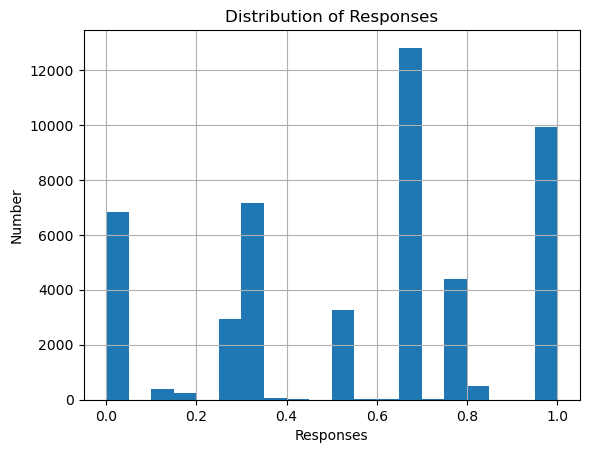

In [16]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')
plt.savefig('../4-figs/distribution_postcovid.png')


In [17]:
resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])
metadata['min_nb_users_logs'] = min_nb_users_logs
metadata['max_nb_categories_per_question'] = int(np.max(resc_data_dim_grouped_items))

### Compute nb of modalities per item

In [18]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb_modalities

In [19]:
new_order = ['user_id','item_id', 'correct', 'dimension_id']
resc_data = resc_data[new_order]

In [20]:
# save selected data
resc_data.to_csv('../1-raw_data/postcovid_selected_data.csv', index=False)

In [21]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('../2-preprocessed_data/postcovid_concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [22]:
# save metadata
with open('../2-preprocessed_data/postcovid_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [23]:
# save metadata
torch.save(nb_modalities,'../2-preprocessed_data/postcovid_nb_modalities.pkl')

## parse data

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from liriscat import utils
utils.setuplogger(verbose = True,log_path = "../../logs/", log_name="liriscat", os='Windows')
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


In [26]:
import pandas as pd
from liriscat.dataset.preprocessing_utilities import *
resc_data = pd.read_csv('../1-raw_data/postcovid_selected_data.csv')

In [27]:
train, valid, test = split_users(resc_data, 5)

In [28]:
for i_fold, train_fold in enumerate(train):
    save_df_to_csv(train[i_fold], f'../2-preprocessed_data/postcovid_train_{i_fold}.csv')
    save_df_to_csv(valid[i_fold], f'../2-preprocessed_data/postcovid_valid_{i_fold}.csv')
    save_df_to_csv(test[i_fold], f'../2-preprocessed_data/postcovid_test_{i_fold}.csv')

    train_valid_df = pd.concat([train[i_fold], valid[i_fold]])
    # Split the merged data horizontally into train and validation sets.

    quadruplet = quadruplet_format(train_valid_df)
    vertical_train, vertical_valid = split_data_vertically_unique_fold(quadruplet, valid_prop=0.1)

    save_df_to_csv(vertical_train, f'../2-preprocessed_data/postcovid_vert_train_{i_fold}.csv')
    save_df_to_csv(vertical_valid, f'../2-preprocessed_data/postcovid_vert_valid_{i_fold}.csv')

